This notebook is to create the model for BERT-QA and BERT-NLI

Please ensure that your **runtime type** is set to **TPU**

Runtime > change runtime type > TPU

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install -r /path/to/BERT-ABSA/requirements.txt

In [ ]:
!pip install transformers==3

     |████████████████████████████████| 757kB 5.0MB/s 
     |████████████████████████████████| 1.2MB 10.0MB/s 
     |████████████████████████████████| 3.0MB 22.9MB/s 
  Found existing installation: tokenizers 0.10.2
    Uninstalling tokenizers-0.10.2:
      Successfully uninstalled tokenizers-0.10.2
  Found existing installation: transformers 4.5.1
    Uninstalling transformers-4.5.1:
      Successfully uninstalled transformers-4.5.1


# Installations of libraries and declarations of TPU

In [ ]:
import os
import json
import numpy as np

!pip install tensorflow_addons
import tensorflow as tf
# from tensorflow.keras.layers import Dense, Embedding, Input, Flatten, Concatenate
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_addons as tfa

from sklearn.model_selection import train_test_split

from transformers import BertTokenizer, TFBertModel, BertConfig
from transformers import *

     |████████████████████████████████| 706kB 4.9MB/s 


In [ ]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


Running on TPU  grpc://10.79.102.242:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.79.102.242:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.79.102.242:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


# Data Preprocessing

This is to handle the text processing for different tasks

In [ ]:
def pad_and_truncate(sequence, maxlen, dtype='int64', padding='post', truncating='post', value=0):
    x = (np.ones(maxlen) * value).astype(dtype)
    if truncating == 'pre':
        trunc = sequence[-maxlen:]
    else:
        trunc = sequence[:maxlen]
    trunc = np.asarray(trunc, dtype=dtype)
    if padding == 'post':
        x[:len(trunc)] = trunc
    else:
        x[-len(trunc):] = trunc
    return x

def get_dataset(data_path, tokenizer):

    with open(data_path) as f:
        json_data = json.load(f)

    bqa, bqam, bqaid, bnli, bnlim, bnliid, p = [], [], [], [], [], [], []

    # {'neutral': 0, 'positive': 1, 'negative': -1}
    polarity_dict = json_data["polarity_library"]
    # {'service': 1, 'food': 2, 'anecdotes/miscellaneous': 3, 'price': 4, 'ambience': 5}
    # aspect_dict = json_data["aspect_library"]

    # {
    # 'text': 'But the staff was so horrible to us.',
    # 'categories': [{'category': 'service', 'polarity': 'negative', 'polarity_id': -1, 'category_id': 1}],
    # 'terms': [{'term': 'staff', 'polarity': 'negative', 'polarity_id': -1}]
    # }
    for sentence in json_data["data"]:

        text = sentence['text'].lower()
        cat_arr = sentence["categories"]

        text_indices = tokenizer.text_to_sequence(text)
        text_indices = pad_and_truncate(text_indices, tokenizer.max_seq_len)
        text_len = np.sum(text_indices != 0)

        for cat in cat_arr:
            polarity = cat['polarity_id']
            polarity = int(polarity) + 1

            # Bert text----------------------------------------------------------------------------------------------

            #bert QA_M
            text_QA_M = "what do you think of the " + cat['category'] + " of it?"
            bert_QA_M = tokenizer.text_to_sequence(text + ' [SEP] ' + text_QA_M)
            bert_QA_M = pad_and_truncate(bert_QA_M, tokenizer.max_seq_len)

            #bert NLI_M
            bert_NLI_M = tokenizer.text_to_sequence(text + ' [SEP] ' + cat['category'])
            bert_NLI_M = pad_and_truncate(bert_NLI_M, tokenizer.max_seq_len)

            # token_type_ids----------------------------------------------------------------------------------------------
            # Segment token indices to indicate first and second portions of the inputs. Indices are selected in [0, 1]:

            #bert_QA_M
            bert_QA_M_len = tokenizer.text_to_sequence(text_QA_M, add_special_tokens=True)
            bert_QA_M_len = pad_and_truncate(bert_QA_M_len, tokenizer.max_seq_len)
            bert_QA_M_len = np.sum(bert_QA_M_len != 0)
            bert_QA_M_token = [0] * (text_len-1) + [1] * bert_QA_M_len # already included + 2 tokens
            bert_QA_M_token = pad_and_truncate(bert_QA_M_token, tokenizer.max_seq_len)

            #bert_NLI_M
            bert_NLI_M_len = tokenizer.text_to_sequence(cat['category'], add_special_tokens=True)
            bert_NLI_M_len = pad_and_truncate(bert_NLI_M_len, tokenizer.max_seq_len)
            bert_NLI_M_len = np.sum(bert_NLI_M_len != 0)
            bert_NLI_M_token = [0] * (text_len-1) + [1] * bert_NLI_M_len # already included + 2 tokens
            bert_NLI_M_token = pad_and_truncate(bert_NLI_M_token, tokenizer.max_seq_len)

            # attention_mask----------------------------------------------------------------------------------------------

            #bert_QA_M
            bert_QA_M_attention_mask = [1] * (text_len+bert_QA_M_len-1) + [0]
            bert_QA_M_attention_mask = pad_and_truncate(bert_QA_M_attention_mask, tokenizer.max_seq_len)

            #bert_NLI_M
            bert_NLI_M_attention_mask = [1] * (text_len+bert_NLI_M_len-1) + [0]
            bert_NLI_M_attention_mask = pad_and_truncate(bert_NLI_M_attention_mask, tokenizer.max_seq_len)

            bqa.append(bert_QA_M)
            bqam.append(bert_QA_M_attention_mask)
            bqaid.append(bert_QA_M_token)
            bnli.append(bert_NLI_M)
            bnlim.append(bert_NLI_M_attention_mask)
            bnliid.append(bert_NLI_M_token)
            p.append(polarity)

    return {
            'bert_QA_M': bqa,
            'bert_QA_M_attention_mask': bqam,
            'bert_QA_M_token_id': bqaid,
            'bert_NLI_M': bnli,
            'bert_NLI_M_attention_mask': bnlim,
            'bert_NLI_M_token_id': bnliid,
            'polarity': p
        }


In [ ]:
class Tokeniser:
  def __init__(self, max_seq_len):
      BERT_PRETRAINED_NAME = 'bert-base-uncased'
      self.tokeniser = BertTokenizer.from_pretrained(BERT_PRETRAINED_NAME)
      self.max_seq_len = max_seq_len

  def text_to_sequence(self, text, add_special_tokens=True):
      sequence = self.tokeniser.encode(text, add_special_tokens=add_special_tokens) # max_length=self.max_seq_len, truncation=truncate, padding=padding
      if len(sequence) == 0:
          sequence = [0]
      return sequence

you need to select your task your task for the classification 

bert-qa/ bert-nli

In [ ]:
TASK_NAME = 'bert-qa'

In [ ]:
BERT_PRETRAINED_NAME = 'bert-base-uncased'
MAX_SEQ_LEN = 128

TRAIN_PATH='/path/to/BERT-ABSA/datasets/json_without_conflict/Restaurants_Train.json'
TEST_PATH='/path/to/BERT-ABSA/datasets/json_without_conflict/Restaurants_Test.json'
BERT_PRETRAINED_NAME = 'bert-base-uncased'


In [ ]:
tokenizer = Tokeniser(MAX_SEQ_LEN)
# pre_split_train = get_dataset(TRAIN_PATH, tokenizer)
train = get_dataset(TRAIN_PATH, tokenizer)
test = get_dataset(TEST_PATH, tokenizer)

Declaration of weight classes

In [ ]:
from sklearn.utils import compute_class_weight

class_weights = compute_class_weight('balanced', np.unique(train['polarity']), train['polarity'])
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

{0: 4.535756853396901, 1: 7.595808383233533, 2: 1.747245179063361, 3: 0.32514524948735474}


In [ ]:
NUM_CLASSES = len(np.unique(train['polarity']))
EPOCH = 50
LR = 2e-5
BATCH_SIZE = 24 * strategy.num_replicas_in_sync
steps_per_epoch = len(train['polarity']) // BATCH_SIZE
validation_steps= len(test['polarity']) // BATCH_SIZE
DROPOUT_VALUE = 0.4

# Model

building the model using TFBertForSequenceClassification

In [ ]:
with strategy.scope():
  model = TFBertForSequenceClassification.from_pretrained(BERT_PRETRAINED_NAME, hidden_dropout_prob=DROPOUT_VALUE, num_labels=NUM_CLASSES)

- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print('\nBert Model',model.summary())

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  3076      
Total params: 109,485,316
Trainable params: 109,485,316
Non-trainable params: 0
_________________________________________________________________

Bert Model None


Training the model

In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics

input_colses = {
        "bert-qa": ["bert_QA_M", "bert_QA_M_attention_mask", "bert_QA_M_token_id"],
        "bert-nli": ["bert_NLI_M", "bert_NLI_M_attention_mask", "bert_NLI_M_token_id"]
    }

inputs_cols = input_colses[TASK_NAME]

AUTO = tf.data.experimental.AUTOTUNE
train_dataset = (
  tf.data.Dataset
  .from_tensor_slices(({"input_ids": list(train[inputs_cols[0]]), "attention_mask": list(train[inputs_cols[1]]), "token_type_ids": list(train[inputs_cols[2]])},list(train['polarity'])))
  .batch(BATCH_SIZE)
  .repeat()
  .cache()
  .prefetch(AUTO)
)

valid_dataset = (
  tf.data.Dataset
  .from_tensor_slices(({"input_ids": list(test[inputs_cols[0]]), "attention_mask": list(test[inputs_cols[1]]), "token_type_ids": list(test[inputs_cols[2]])}, list(test['polarity'])))
  .batch(BATCH_SIZE)
  .repeat()
  .cache()
  .prefetch(AUTO)
)

with strategy.scope():
  callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

  model.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #tf.nn.sparse_softmax_cross_entropy_with_logits 
                     optimizer= tf.keras.optimizers.Adam(learning_rate=LR,epsilon=1e-08),
                     metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])


  print("currently training for :", TASK_NAME)
  # tpu
  hist = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCH,
    class_weight=d_class_weights,
    # batch_size=batch_size,
    shuffle=True,
    # validation_split=0.2,
    validation_data=valid_dataset,
    validation_steps=validation_steps,
    callbacks=[reduce_lr, callback]
  )


currently training for : bert-qa
Epoch 1/50
79/79 [==============================] - 99s 297ms/step - loss: 1.3337 - accuracy: 0.3529 - val_loss: 1.0552 - val_accuracy: 0.6573
Epoch 2/50
79/79 [==============================] - 56s 182ms/step - loss: 1.1456 - accuracy: 0.6627 - val_loss: 0.6485 - val_accuracy: 0.8193
Epoch 3/50
79/79 [==============================] - 14s 182ms/step - loss: 0.9697 - accuracy: 0.7349 - val_loss: 0.5640 - val_accuracy: 0.8391
Epoch 4/50
79/79 [==============================] - 14s 182ms/step - loss: 0.8251 - accuracy: 0.7564 - val_loss: 0.4810 - val_accuracy: 0.8596
Epoch 5/50
79/79 [==============================] - 15s 188ms/step - loss: 0.6942 - accuracy: 0.8021 - val_loss: 0.4436 - val_accuracy: 0.8698
Epoch 6/50
79/79 [==============================] - 14s 182ms/step - loss: 0.6155 - accuracy: 0.8246 - val_loss: 0.4086 - val_accuracy: 0.8820
Epoch 7/50
79/79 [==============================] - 14s 181ms/step - loss: 0.5483 - accuracy: 0.8376 - val_lo

# Evaluation of models and results

------------------------ THIS IS RESULTS FOR  BERT-QA --------------------------



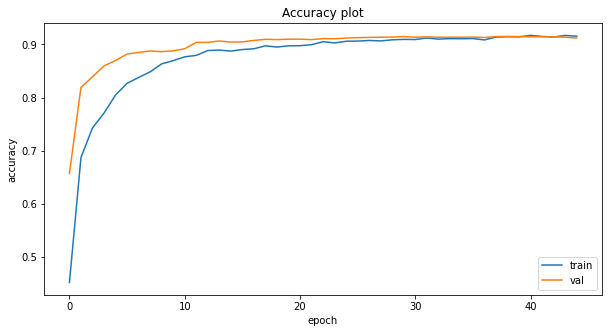

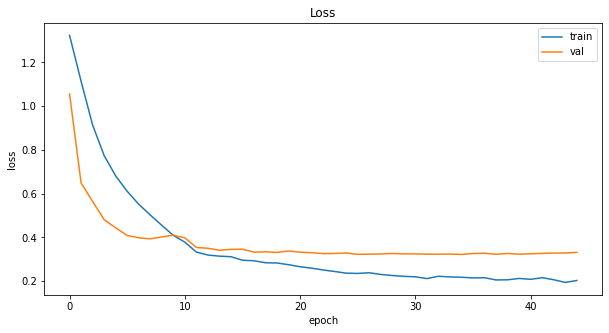

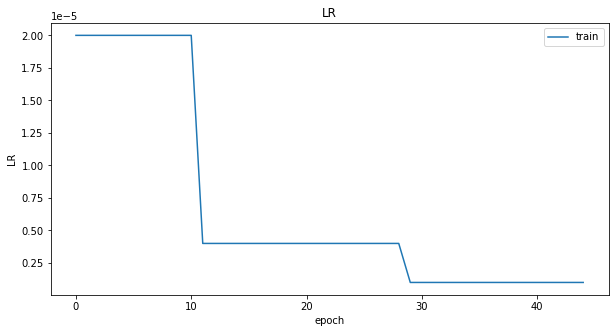

21/21 [==============================] - 2s 50ms/step
              precision    recall  f1-score   support

    Negative       0.64      0.81      0.71       222
     Neutral       0.49      0.59      0.53        94
    Positive       0.80      0.91      0.85       657
        None       0.98      0.93      0.95      3027

    accuracy                           0.91      4000
   macro avg       0.73      0.81      0.76      4000
weighted avg       0.92      0.91      0.91      4000



In [ ]:
print('------------------------ THIS IS RESULTS FOR ', TASK_NAME.upper(), '--------------------------')
print()

plt.figure(figsize=(10,5))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(hist.history['lr'])
plt.title('LR')
plt.ylabel('LR')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

target_names = ['Negative', 'Neutral', 'Positive', 'None'] if NUM_CLASSES == 4 else ['Negative', 'Neutral', 'Positive', 'Conflicts', 'None']

test_dataset = (
      tf.data.Dataset
      .from_tensor_slices(({"input_ids": list(test[inputs_cols[0]]), "attention_mask": list(test[inputs_cols[1]]), "token_type_ids": list(test[inputs_cols[2]])}))
      .batch(BATCH_SIZE)
      .prefetch(AUTO)
    )

predictions = model.predict(test_dataset, verbose=1)
predictions = tf.nn.softmax(tf.constant(predictions)[0])
# print(predictions)
y_pred_argmax = np.argmax(tf.constant(predictions), axis=1)#tf.math.argmax(y_pred, axis=1)
print(metrics.classification_report(list(test['polarity']), y_pred_argmax, target_names=target_names))


# Original results from the experiments

These are the results from the experiments in the papers

Semeval dataset * WITHOUT CONFLICT* sentiment

It involves None, Negative, Neutral, Positive

### Bert-NLI

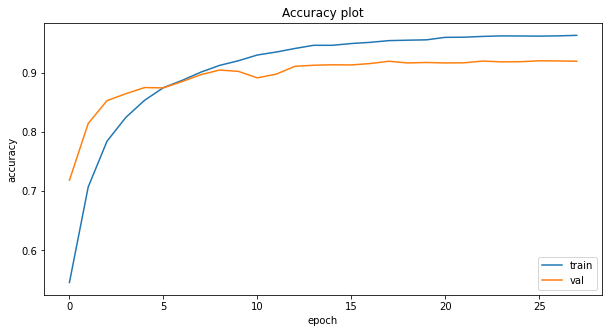

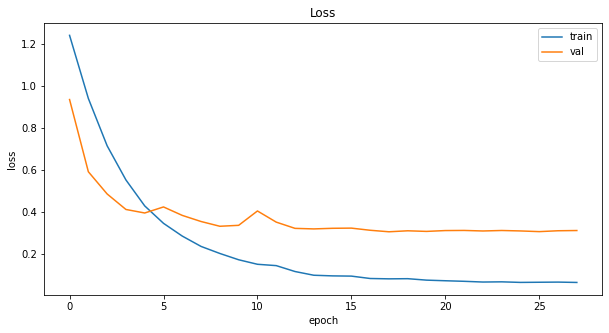

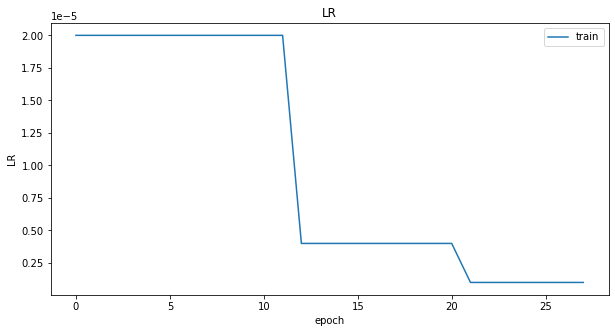

21/21 [==============================] - 15s 557ms/step
              precision    recall  f1-score   support

    Negative       0.64      0.83      0.72       222
     Neutral       0.56      0.64      0.60        94
    Positive       0.85      0.88      0.86       657
        None       0.97      0.94      0.96      3027

    accuracy                           0.92      4000
   macro avg       0.76      0.82      0.79      4000
weighted avg       0.93      0.92      0.92      4000



In [ ]:
plt.figure(figsize=(10,5))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(hist.history['lr'])
plt.title('LR')
plt.ylabel('LR')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

target_names = ['Negative', 'Neutral', 'Positive', 'None'] if NUM_CLASSES == 4 else ['Negative', 'Neutral', 'Positive', 'Conflicts', 'None']
# target_names = ['Negative', 'Neutral', 'Positive', 'Conflicts']
# target_names = ['Negative', 'Neutral', 'Positive']

test_dataset = (
      tf.data.Dataset
      .from_tensor_slices(({"input_ids": list(test[inputs_cols[0]]), "attention_mask": list(test[inputs_cols[1]]), "token_type_ids": list(test[inputs_cols[2]])}))
      .batch(BATCH_SIZE)
      .prefetch(AUTO)
    )

predictions = model.predict(test_dataset, verbose=1)
predictions = tf.nn.softmax(tf.constant(predictions)[0])
# print(predictions)
y_pred_argmax = np.argmax(tf.constant(predictions), axis=1)#tf.math.argmax(y_pred, axis=1)
print(metrics.classification_report(list(test['polarity']), y_pred_argmax, target_names=target_names))


### Bert-QA

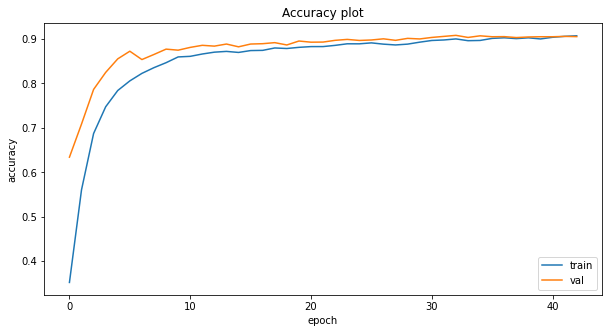

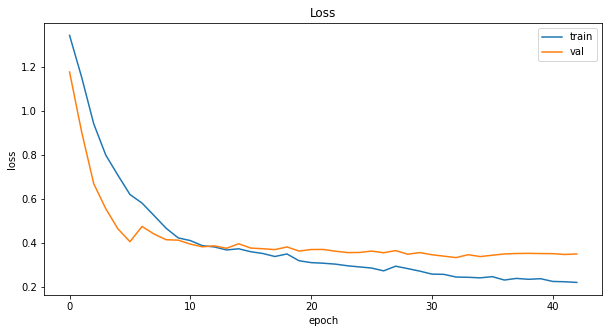

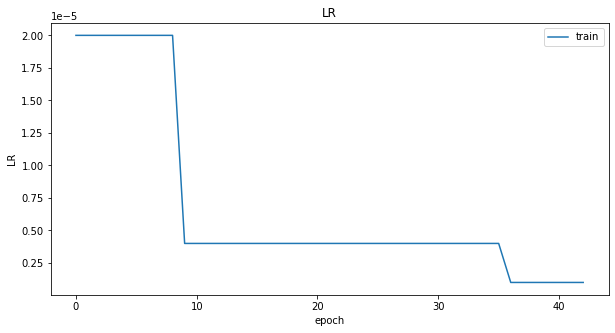

21/21 [==============================] - 2s 50ms/step
              precision    recall  f1-score   support

    Negative       0.59      0.82      0.68       222
     Neutral       0.49      0.66      0.56        94
    Positive       0.81      0.89      0.85       657
        None       0.98      0.92      0.95      3027

    accuracy                           0.91      4000
   macro avg       0.72      0.82      0.76      4000
weighted avg       0.92      0.91      0.91      4000



In [ ]:
plt.figure(figsize=(10,5))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(hist.history['lr'])
plt.title('LR')
plt.ylabel('LR')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

target_names = ['Negative', 'Neutral', 'Positive', 'None'] if NUM_CLASSES == 4 else ['Negative', 'Neutral', 'Positive', 'Conflicts', 'None']

test_dataset = (
      tf.data.Dataset
      .from_tensor_slices(({"input_ids": list(test[inputs_cols[0]]), "attention_mask": list(test[inputs_cols[1]]), "token_type_ids": list(test[inputs_cols[2]])}))
      .batch(BATCH_SIZE)
      .prefetch(AUTO)
    )

predictions = model.predict(test_dataset, verbose=1)
predictions = tf.nn.softmax(tf.constant(predictions)[0])
# print(predictions)
y_pred_argmax = np.argmax(tf.constant(predictions), axis=1)#tf.math.argmax(y_pred, axis=1)
print(metrics.classification_report(list(test['polarity']), y_pred_argmax, target_names=target_names))
